In [1]:
import pandas as pd
import numpy as np
import matplotlib as mth

In [2]:
df_gas = pd.read_csv('C:/Users/ednae/Documents/Linguagens/data2/df_gas.csv')

C:\Users\ednae\anaconda3\envs\rsd\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (1,3,7,17,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Tratamento inicial
- ## Ajuste de tipo das datas
- ## Ordenação por data
- ## Mudança do index

In [3]:
df_gas['Data da Coleta']=pd.to_datetime(df_gas['Data da Coleta'],format="%d/%m/%Y")
df_gas.sort_values('Data da Coleta',inplace=True)
df_gas.set_index('Data da Coleta',drop=False,inplace=True)
df_gas.rename_axis('Período',inplace=True)

# Remoção de dados desnecessários e/ou incompletos

In [4]:
df_gas.isna().sum()

Período                    0
Regiao - Sigla        146151
Estado - Sigla             0
Municipio             146151
Revenda                    0
CNPJ da Revenda            0
Nome da Rua                0
Numero Rua            148238
Complemento          2682576
Bairro                 11970
Cep                        0
Produto                    0
Data da Coleta             0
Valor de Venda             0
Valor de Compra      2074799
Unidade de Medida          0
Bandeira                   0
Região - Sigla       3435492
Município            3435492
Número Rua           3435557
dtype: int64

In [5]:
df_gas.drop(['Municipio','Complemento'],axis=1,inplace=True)
df_gas.drop(['Bandeira'],axis=1,inplace=True)
df_gas.drop(['Município','Cep','Número Rua','Numero Rua','Regiao - Sigla','Região - Sigla'],axis=1,inplace=True)

- ## Informações acerca da coleta
- ## Contagens

<AxesSubplot:>

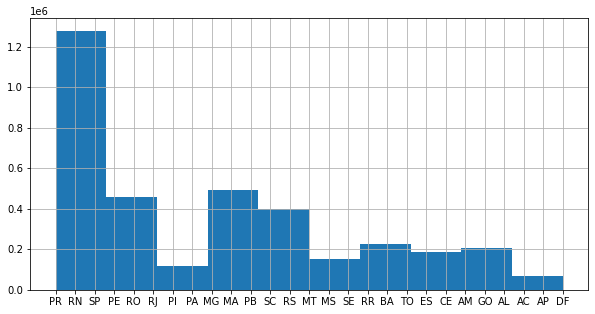

In [6]:
df_gas['Estado - Sigla'].hist(figsize=(10,5))

<AxesSubplot:>

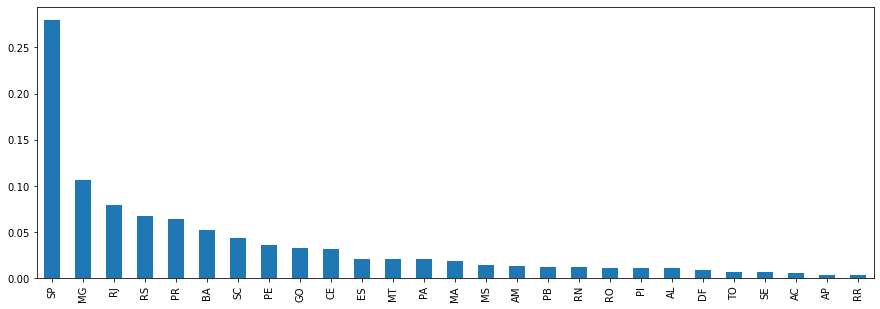

In [28]:
(df_gas['Estado - Sigla'].value_counts()/3581643).plot.bar(figsize=(15,5))
#colocar em cima de cada barra o valor percentual

## Preparação para visualização

In [8]:
df_gas['ano']=df_gas['Data da Coleta'].dt.year
df_gas['mes']=df_gas['Data da Coleta'].dt.month
df_gas['dia']=df_gas['Data da Coleta'].dt.day

## Plot: Todas as observações diárias e mensais

array([<AxesSubplot:xlabel='ano,mes'>, <AxesSubplot:xlabel='ano,mes'>],
      dtype=object)

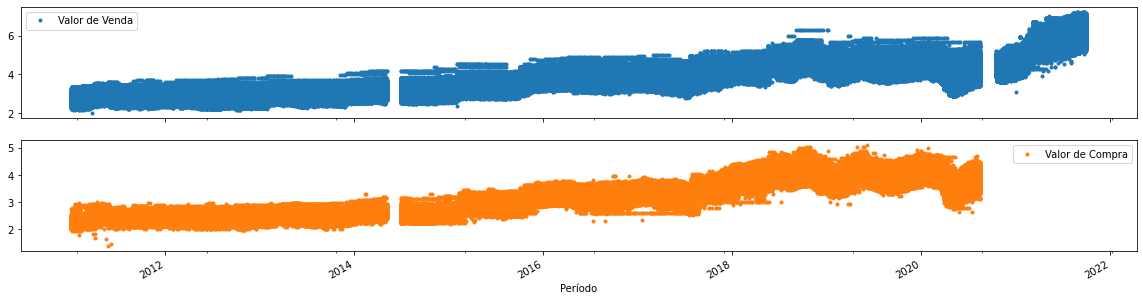

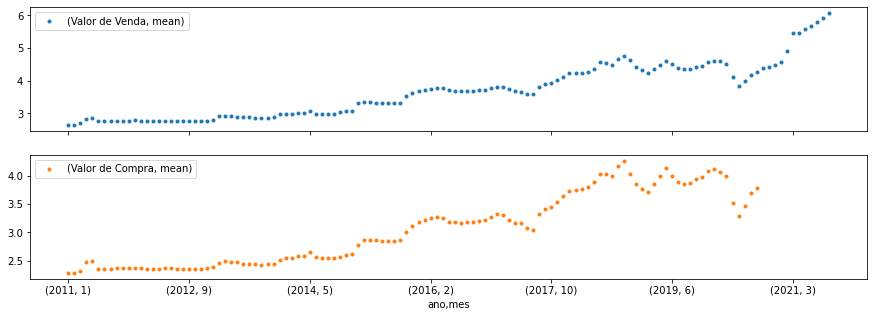

In [9]:
gp=df_gas[['Valor de Venda','Valor de Compra']].plot(marker='.',figsize=(20,5),subplots=True,linestyle='None')
resumo_gas=df_gas.groupby(['ano','mes']).agg({'Valor de Venda':['mean'],'Valor de Compra':['mean']})
resumo_gas.plot(marker='.',figsize=(15,5),linewidth=1,subplots=True,linestyle='None')

## Olhando apenas para os valores de vendas, que são nosso objeto de interesse

<AxesSubplot:xlabel='ano,mes'>

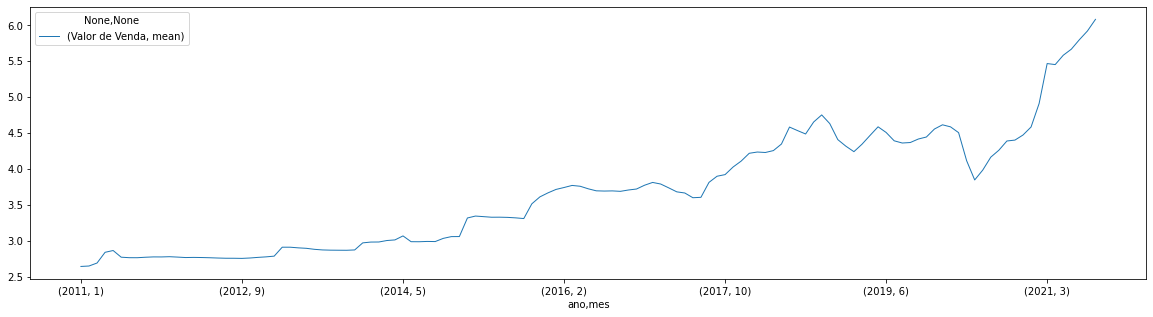

In [10]:
resumo_gas=df_gas.groupby(['ano','mes']).agg({'Valor de Venda':['mean']})
resumo_gas.plot(figsize=(20,5),linewidth=1)

## Reorganizando a série

In [11]:
colunas=['Valor de Venda','Valor de Compra']
gas_med_semanal = df_gas[colunas].resample('W').mean()
gas_med_diaria = df_gas['Valor de Venda'].resample('D').mean() #agora cada dia virou uma soh observacao
gas_med_mensal = df_gas['Valor de Venda'].resample('M').mean()
print(gas_med_semanal.shape)
print(gas_med_diaria.shape)
print(df_gas.shape)
print(gas_med_mensal.shape)

(561, 2)
(3924,)
(3581643, 14)
(129,)


### COMPORTAMENTO NO CONTROLE DE PREÇO

Text(0.5, 0, 'Período do controle de preço')

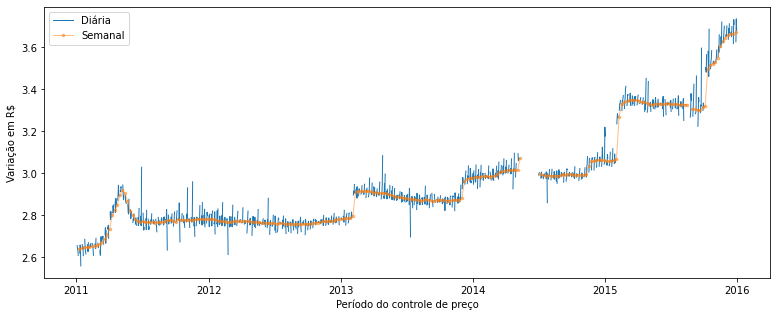

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13,5))
plt.plot(gas_med_diaria.loc['2011':'2015'],markersize=8,linestyle='-',linewidth=1,label='Diária')
plt.plot(gas_med_semanal.loc['2011':'2015','Valor de Venda'],marker='.',linestyle='-',linewidth=1,markersize=5,alpha=0.5,label='Semanal')
plt.legend()
plt.ylabel('Variação em R$')
plt.xlabel('Período do controle de preço')

### Decomposição da série - sazonalidade e tendência

In [24]:
12/10-1

0.19999999999999996

In [13]:
#REMOÇÃO DE NA'S anterior-p´roximo-1
gas_med_diaria.dropna(inplace=True)
gas_med_semanal.dropna(inplace=True)
gas_med_mensal.dropna(inplace=True)

<AxesSubplot:xlabel='Período'>

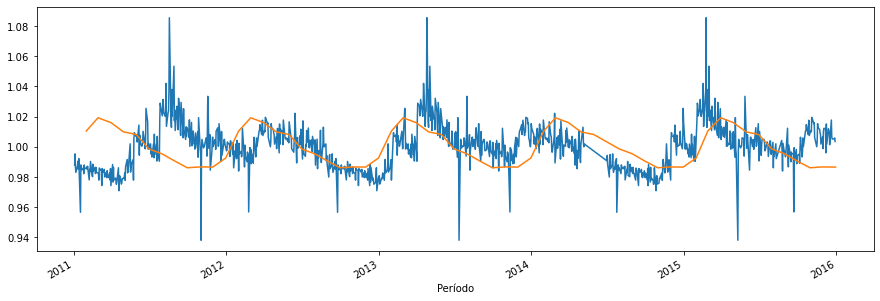

In [15]:
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

result=seasonal_decompose(gas_med_diaria.loc[:'2015'], model='multiplicable', period=360)
result.seasonal.plot(figsize=(15,5))
result2=seasonal_decompose(gas_med_mensal.loc[:'2015'], model='multiplicable', period=12)
result2.seasonal.plot(figsize=(15,5))

<AxesSubplot:xlabel='Período'>

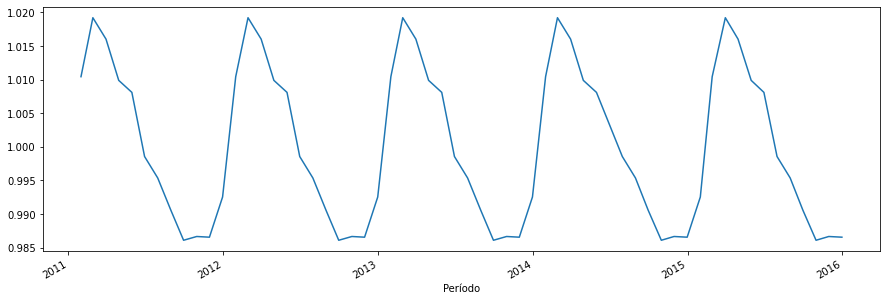

In [16]:
result2=seasonal_decompose(gas_med_mensal.loc[:'2015'], model='multiplicable', period=12)
result2.seasonal.plot(figsize=(15,5))

<AxesSubplot:xlabel='Período'>

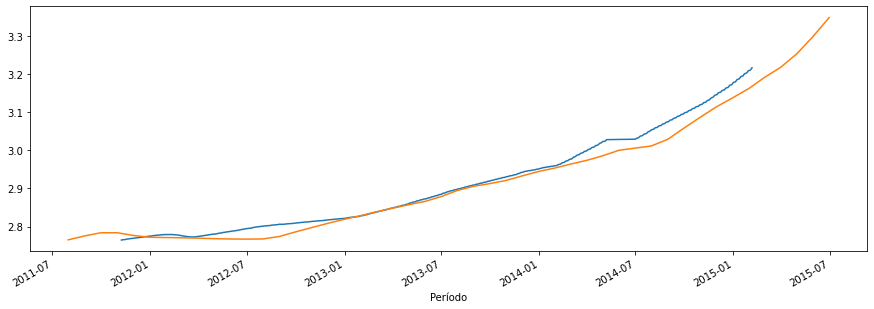

In [17]:
result.trend.plot(figsize=(15,5))
result2.trend.plot(figsize=(15,5))

### COMPORTAMENTO NO PPI

Text(0.5, 0, 'Período do PPI (incluindo pandemia)')

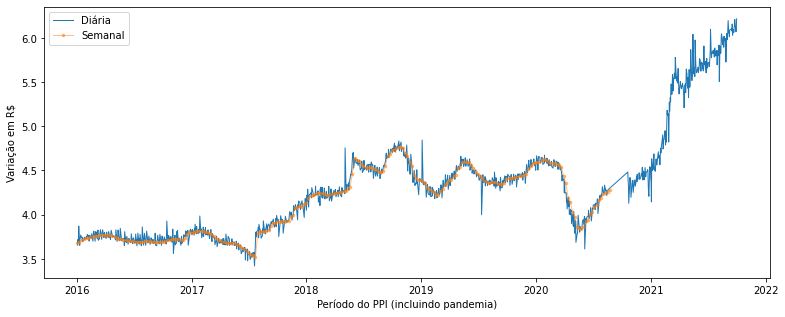

In [18]:
plt.figure(figsize=(13,5))
plt.plot(gas_med_diaria.loc['2016':],markersize=8,linestyle='-',linewidth=1,label='Diária')
plt.plot(gas_med_semanal.loc['2016':,'Valor de Venda'],marker='.',linestyle='-',linewidth=1,markersize=5,alpha=0.5,label='Semanal')
plt.legend()
plt.ylabel('Variação em R$')
plt.xlabel('Período do PPI (incluindo pandemia)')

In seasonal_decompose we have to set the model. We can either set the model to be Additive or Multiplicative. A rule of thumb for selecting the right model is to see in our plot if the trend and seasonal variation are relatively constant over time, in other words, linear. If yes, then we will select the Additive model. Otherwise, if the trend and seasonal variation increase or decrease over time then we use the Multiplicative model.

explicação do uso do modelo multiplicativo - buscar mais referencias

<AxesSubplot:xlabel='Período'>

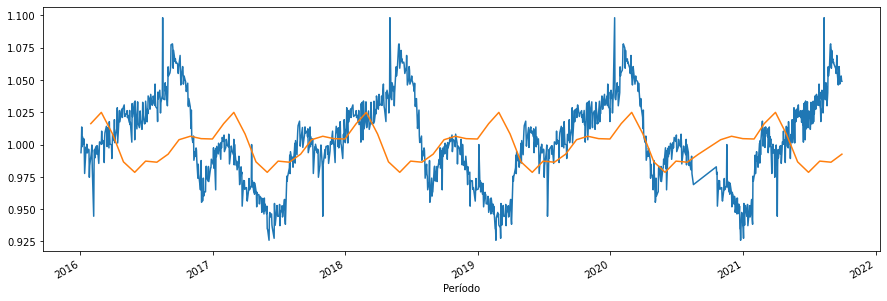

In [19]:
result=seasonal_decompose(gas_med_diaria.loc['2016':], model='multiplicable', period=360)
result.seasonal.plot(figsize=(15,5))
result2=seasonal_decompose(gas_med_mensal.loc['2016':], model='multiplicable', period=12)
result2.seasonal.plot(figsize=(15,5))

<AxesSubplot:xlabel='Período'>

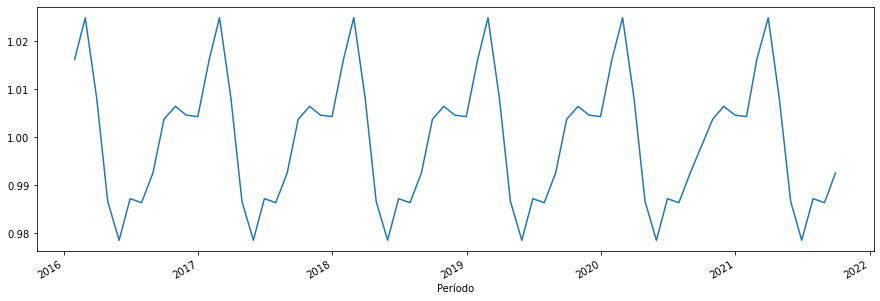

In [20]:
result2=seasonal_decompose(gas_med_mensal.loc['2016':], model='multiplicable', period=12)
result2.seasonal.plot(figsize=(15,5))

<AxesSubplot:xlabel='Período'>

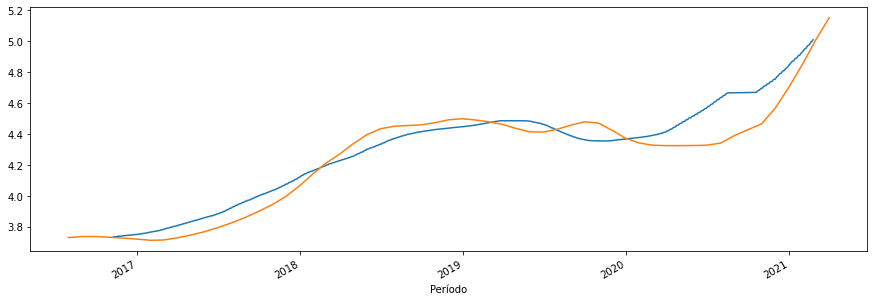

In [21]:
result.trend.plot(figsize=(15,5))
result2.trend.plot(figsize=(15,5))

<AxesSubplot:xlabel='Período'>

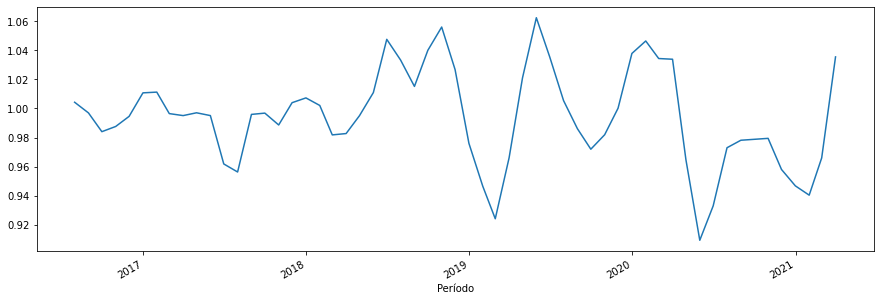

In [26]:
result2.resid.plot(figsize=(15,5))